In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
import random
import tqdm
import torch as tc
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
! pip install torchsummary
from torchsummary import summary
import gc
from google.colab import drive
import time

In [2]:
drive.mount('/content/drive')
path = "/content/drive/My Drive/Brain_tumor"

path_testing = path + "/crop_square_test"
path_training = path + "/crop_square_train"

list_train = os.listdir(path_training)
list_test = os.listdir(path_testing)
print(list_train)
print(list_test)

Mounted at /content/drive
['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']
['glioma_tumor', 'no_tumor', 'pituitary_tumor', 'meningioma_tumor']


In [3]:
# training dataset 
train_glioma = path_training + "/glioma_tumor"
train_meningioma = path_training + "/meningioma_tumor"
train_no_tumor = path_training + "/no_tumor"
train_pituitary = path_training + "/pituitary_tumor"

print(f'train glioma: {len(os.listdir(train_glioma))}')
print(f'train meningioma: {len(os.listdir(train_meningioma))}')
print(f'train no tumor: {len(os.listdir(train_no_tumor))}')
print(f'train pituitary: {len(os.listdir(train_pituitary))}')

# testing dataset
test_glioma = path_testing + "/glioma_tumor"
test_meningioma = path_testing + "/meningioma_tumor"
test_no_tumor = path_testing + "/no_tumor"
test_pituitary = path_testing + "/pituitary_tumor"

print(f'test glioma: {len(os.listdir(test_glioma))}')
print(f'test meningioma: {len(os.listdir(test_meningioma))}')
print(f'test no tumor: {len(os.listdir(test_no_tumor))}')
print(f'test pituitary: {len(os.listdir(test_pituitary))}')

train glioma: 826
train meningioma: 822
train no tumor: 395
train pituitary: 827
test glioma: 100
test meningioma: 115
test no tumor: 105
test pituitary: 74


In [4]:
class TumorDataset(tc.utils.data.Dataset):
  def __init__(self, image_paths, image_labels, transforms):
    self.image_paths = image_paths
    self.labels = image_labels
    self.transforms = transforms

  def __getitem__(self,i):
    image = plt.imread(self.image_paths[i])
    label = self.labels[i]
    image = self.transforms(image)
    return image, label

  def __len__(self):
    return len(self.image_paths)

def labels(filename, main_path):
    if filename[len(main_path)+1] == "g":
        label = 0
    elif filename[len(main_path)+1] == "m":
        label = 1
    elif filename[len(main_path)+1] == "p":
        label = 2
    else:
        label = 3
    return label

classes = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

In [5]:
train_path = [path_training + '/' + i + '/' + img 
                    for i in os.listdir(path_training) 
                    for img in os.listdir(path_training + '/' + i)
                    ]

test_path = [path_testing + '/' + i + '/' + img 
                  for i in os.listdir(path_testing) 
                  for img in os.listdir(path_testing + '/' + i)
                  ]


In [6]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((224,224)),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                #transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.8),
                                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                #transforms.GaussianBlur(kernel_size=5),
                                ])

augmentation = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(p=1),
                                ])

augmentation2 = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((224,224)),
                                transforms.RandomRotation(degrees=90),
                                ])

augmentation3 = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((224,224)),
                                transforms.RandomRotation(degrees=270),
                                ])

In [7]:
train_label = [labels(data, path_training) for data in train_path]
test_label = [labels(data, path_testing) for data in test_path]
print(f"Train: {len(train_label)}")
print(f"Test: {len(test_label)}")

#Validation dataset 
train_path, validation_path, train_label, validation_label = train_test_split(train_path, train_label, test_size=0.05, random_state = 1, stratify=train_label) 
print(f"Validation: {len(validation_path)}")
print(f"Train after split: {len(train_path)}")

Train: 2870
Test: 394
Validation: 144
Train after split: 2726


In [8]:
print("Validation set:\n")
for i in range(4):
  print(classes[i], '-', len(np.where(np.array(validation_label) == i)[0]))

Validation set:

Glioma - 41
Meningioma - 41
Pituitary - 42
No Tumor - 20


In [9]:
print("Training set:\n")
for i in range(4):
  print(classes[i], '-', len(np.where(np.array(train_label) == i)[0]))

Training set:

Glioma - 785
Meningioma - 781
Pituitary - 785
No Tumor - 375


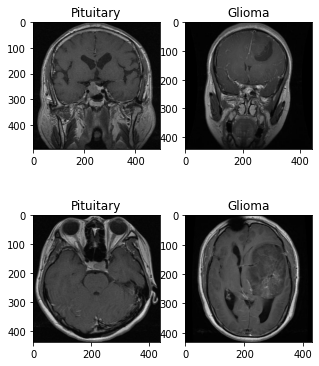

In [10]:
# random image from train Dataset (before resizing)
plt.figure(figsize=(5,6.5))
for i in range(4):
  n = random.randint(0, len(train_path)-1)
  image = plt.imread(train_path[n])
  plt.subplot(2,2,i+1)
  plt.imshow(image)
  plt.title(classes[train_label[n]])
plt.show()

In [11]:
# augmentation train no tumor
no_tumor_train_path = [path_training + "/no_tumor/" + img 
                    for img in os.listdir(path_training + "/no_tumor")
                    ]

no_tumor_label = [labels(data, path_training) for data in no_tumor_train_path]
train_no_tumor_dataset1 = TumorDataset(no_tumor_train_path, no_tumor_label, transforms=augmentation2) 
train_no_tumor_dataset2 = TumorDataset(no_tumor_train_path, no_tumor_label, transforms=augmentation3) 

In [12]:
train_dataset = TumorDataset(train_path, train_label, transforms=transform) + TumorDataset(train_path, train_label, transforms=augmentation) + train_no_tumor_dataset1 + train_no_tumor_dataset2
test_dataset = TumorDataset(test_path, test_label, transforms=transform)
validation_dataset = TumorDataset(validation_path, validation_label, transforms=transform)

batch_size = 4
num_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)


print(f'train dataset after augmentation: {len(train_dataset)}')

train dataset after augmentation: 6242


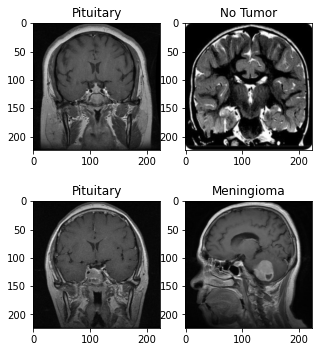

In [13]:
# random image from train DataLoader (after resizing)
plt.figure(figsize=(5,6))
for i in range(4):
  for images, labels in train_dataloader:
    plt.subplot(2,2,i+1)
    plt.imshow(images[0, :, :, :].numpy().swapaxes(0, 1).swapaxes(1, 2))
    plt.title(classes[labels[0]])
    break
plt.show()

In [14]:
model = torchvision.models.vgg16(pretrained=True)
device = "cuda:0"     # or "cpu"
model = model.to(device)    # move the model to GPU
summary(model, input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [15]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=7, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [16]:
optimizer = tc.optim.Adam(model.parameters(), lr=0.000001)
cost_function = nn.CrossEntropyLoss()
num_epochs = 100

early_stopping = EarlyStopping()
start = time.time()

train_losses = []
train_accuracy = []
eval_losses = []
eval_accuracy = []

for epoch in range(num_epochs):
  running_loss = 0.0
  correct = 0
  total = 0
  running_val_loss = 0.0
  correct_val = 0
  total_val = 0 
  print(f'Epoch: {epoch+1}')

  model.train()
  for image, label in tqdm.tqdm(train_dataloader, position=0, leave=True):  
    image = image.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    results = model(image)
    loss = cost_function(results, label)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = results.max(1)
    total += label.size(0)
    correct += predicted.eq(label).sum().item()

  train_loss = running_loss / len(train_dataloader)
  accuracy = 100. * correct / total
  
  train_accuracy.append(accuracy)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss, accuracy))


  model.eval()
  with tc.no_grad():
    for image, label in tqdm.tqdm(validation_dataloader, position=0, leave=True):
      
      image = image.to(device)
      label = label.to(device)

      results = model(image)
      val_loss = cost_function(results, label)

      running_val_loss += val_loss.item()
      _, predicted_val = results.max(1)
      total_val += labels.size(0)
      correct_val += predicted_val.eq(label).sum().item()

  val_loss = running_val_loss / len(validation_dataloader)
  accuracy_val = 100. * correct_val / total_val

  eval_losses.append(val_loss)
  eval_accuracy.append(accuracy_val)

  print('Validation Loss: %.3f | Accuracy: %.3f'%(val_loss, accuracy_val))

  early_stopping(val_loss)
  if early_stopping.early_stop:
      break

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch: 1


100%|██████████| 1561/1561 [23:12<00:00,  1.12it/s]


Train Loss: 1.876 | Accuracy: 51.570


100%|██████████| 36/36 [00:41<00:00,  1.14s/it]


Validation Loss: 0.543 | Accuracy: 81.944
Epoch: 2


100%|██████████| 1561/1561 [10:33<00:00,  2.46it/s]


Train Loss: 0.515 | Accuracy: 82.858


100%|██████████| 36/36 [00:06<00:00,  5.34it/s]


Validation Loss: 0.344 | Accuracy: 88.194
Epoch: 3


100%|██████████| 1561/1561 [10:34<00:00,  2.46it/s]


Train Loss: 0.348 | Accuracy: 87.937


100%|██████████| 36/36 [00:06<00:00,  5.49it/s]


Validation Loss: 0.282 | Accuracy: 89.583
Epoch: 4


100%|██████████| 1561/1561 [10:31<00:00,  2.47it/s]


Train Loss: 0.242 | Accuracy: 91.637


100%|██████████| 36/36 [00:06<00:00,  5.32it/s]


Validation Loss: 0.248 | Accuracy: 89.583
Epoch: 5


100%|██████████| 1561/1561 [10:34<00:00,  2.46it/s]


Train Loss: 0.173 | Accuracy: 93.944


100%|██████████| 36/36 [00:06<00:00,  5.43it/s]


Validation Loss: 0.235 | Accuracy: 88.194
Epoch: 6


100%|██████████| 1561/1561 [10:35<00:00,  2.46it/s]


Train Loss: 0.119 | Accuracy: 95.610


100%|██████████| 36/36 [00:06<00:00,  5.45it/s]


Validation Loss: 0.233 | Accuracy: 90.278
Epoch: 7


100%|██████████| 1561/1561 [10:31<00:00,  2.47it/s]


Train Loss: 0.086 | Accuracy: 96.956


100%|██████████| 36/36 [00:06<00:00,  5.49it/s]


Validation Loss: 0.204 | Accuracy: 90.278
Epoch: 8


100%|██████████| 1561/1561 [10:35<00:00,  2.46it/s]


Train Loss: 0.058 | Accuracy: 97.997


100%|██████████| 36/36 [00:06<00:00,  5.53it/s]


Validation Loss: 0.226 | Accuracy: 91.667
INFO: Early stopping counter 1 of 7
Epoch: 9


100%|██████████| 1561/1561 [10:37<00:00,  2.45it/s]


Train Loss: 0.038 | Accuracy: 98.814


100%|██████████| 36/36 [00:06<00:00,  5.49it/s]


Validation Loss: 0.181 | Accuracy: 91.667
Epoch: 10


100%|██████████| 1561/1561 [10:35<00:00,  2.46it/s]


Train Loss: 0.028 | Accuracy: 99.087


100%|██████████| 36/36 [00:06<00:00,  5.34it/s]


Validation Loss: 0.180 | Accuracy: 92.361
Epoch: 11


100%|██████████| 1561/1561 [10:35<00:00,  2.45it/s]


Train Loss: 0.021 | Accuracy: 99.407


100%|██████████| 36/36 [00:06<00:00,  5.46it/s]


Validation Loss: 0.224 | Accuracy: 93.750
INFO: Early stopping counter 2 of 7
Epoch: 12


100%|██████████| 1561/1561 [10:36<00:00,  2.45it/s]


Train Loss: 0.013 | Accuracy: 99.680


100%|██████████| 36/36 [00:06<00:00,  5.41it/s]


Validation Loss: 0.205 | Accuracy: 91.667
INFO: Early stopping counter 3 of 7
Epoch: 13


100%|██████████| 1561/1561 [10:36<00:00,  2.45it/s]


Train Loss: 0.012 | Accuracy: 99.664


100%|██████████| 36/36 [00:06<00:00,  5.34it/s]


Validation Loss: 0.172 | Accuracy: 93.750
Epoch: 14


100%|██████████| 1561/1561 [10:36<00:00,  2.45it/s]


Train Loss: 0.010 | Accuracy: 99.664


100%|██████████| 36/36 [00:06<00:00,  5.45it/s]


Validation Loss: 0.181 | Accuracy: 93.750
INFO: Early stopping counter 4 of 7
Epoch: 15


100%|██████████| 1561/1561 [10:34<00:00,  2.46it/s]


Train Loss: 0.007 | Accuracy: 99.824


100%|██████████| 36/36 [00:06<00:00,  5.44it/s]


Validation Loss: 0.127 | Accuracy: 93.056
Epoch: 16


100%|██████████| 1561/1561 [10:34<00:00,  2.46it/s]


Train Loss: 0.006 | Accuracy: 99.904


100%|██████████| 36/36 [00:06<00:00,  5.50it/s]


Validation Loss: 0.165 | Accuracy: 95.139
INFO: Early stopping counter 5 of 7
Epoch: 17


100%|██████████| 1561/1561 [10:31<00:00,  2.47it/s]


Train Loss: 0.006 | Accuracy: 99.872


100%|██████████| 36/36 [00:06<00:00,  5.63it/s]


Validation Loss: 0.196 | Accuracy: 94.444
INFO: Early stopping counter 6 of 7
Epoch: 18


100%|██████████| 1561/1561 [10:30<00:00,  2.48it/s]


Train Loss: 0.005 | Accuracy: 99.840


100%|██████████| 36/36 [00:06<00:00,  5.49it/s]

Validation Loss: 0.386 | Accuracy: 93.056
INFO: Early stopping counter 7 of 7
INFO: Early stopping
Training time: 205.534 minutes


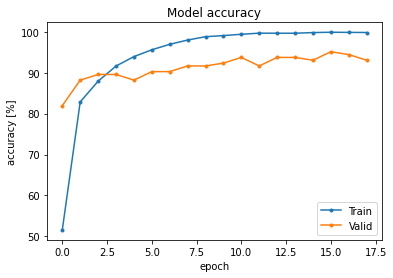

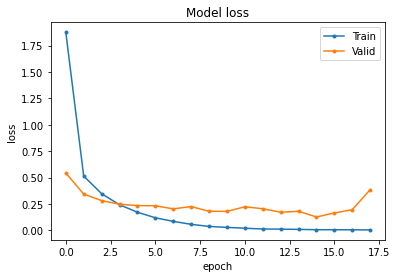

In [17]:
#plot accuracy
plt.plot(train_accuracy,'.-')
plt.plot(eval_accuracy,'.-')
plt.xlabel('epoch')
plt.ylabel('accuracy [%]')
plt.legend(['Train','Valid'], loc="lower right")
plt.title("Model accuracy")
plt.show()

#plot losses
plt.plot(train_losses,'.-')
plt.plot(eval_losses,'.-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title("Model loss")
plt.show()

In [18]:
model.eval()
actuals = []
predictions = []

with tc.no_grad():
  for image, label in test_dataloader:    
    image = image.to(device)                     # GPU
    label = label.to(device)
    results = model(image)             
    prediction = results.argmax(dim=1, keepdim=True)     
    actuals.extend(label.view_as(prediction))        #[]
    predictions.extend(prediction)

actuals = [i.item() for i in actuals]
predictions = [i.item() for i in predictions]

cm = confusion_matrix(actuals, predictions)
print("Confusion Matrix : ")
print(cm)
print('Precision score: %f' % precision_score(actuals, predictions, average='macro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='macro'))
print(classification_report(actuals, predictions)) 

Confusion Matrix : 
[[ 34  28   0  38]
 [  0 110   0   5]
 [  0   8  46  20]
 [  0   0   0 105]]
Precision score: 0.844606
Accuracy score: 0.748731
F1 score: 0.721568
              precision    recall  f1-score   support

           0       1.00      0.34      0.51       100
           1       0.75      0.96      0.84       115
           2       1.00      0.62      0.77        74
           3       0.62      1.00      0.77       105

    accuracy                           0.75       394
   macro avg       0.84      0.73      0.72       394
weighted avg       0.83      0.75      0.72       394



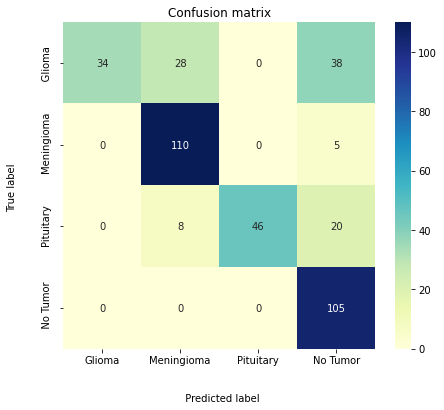

In [19]:
#classes = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']
plt.figure(figsize=(7,6))
sns.heatmap(cm, xticklabels=classes, yticklabels=['','','',''], annot=True, fmt='.3g',  cmap='YlGnBu')   #Reds
plt.ylabel('True label \n \n \n   No Tumor           Pituitary          Meningioma          Glioma    ')
plt.xlabel('\n \n  Predicted label')
plt.title('Confusion matrix')
plt.show()

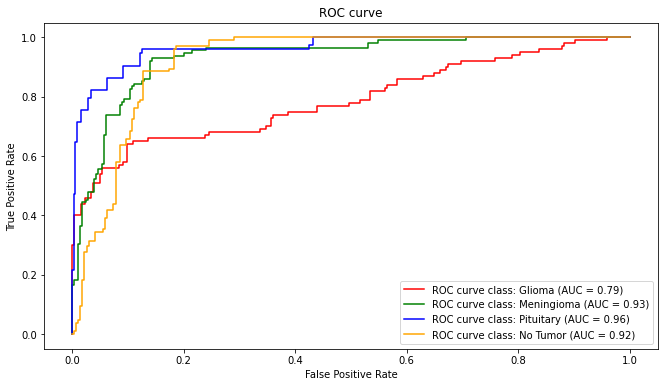

In [20]:
def class_probabilities(number_of_class):
  model.eval()
  actuals = []
  probabilities = []
  with tc.no_grad():
    for image, label in test_dataloader:
      image = image.to(device)
      label = label.to(device)
      results = model(image)
      prediction = results.argmax(dim=1, keepdim=True)
      actuals.extend(label.view_as(prediction) == number_of_class)
      probabilities.extend(np.exp(results.cpu()[:, number_of_class]))

  actuals = [i.item() for i in actuals]
  probabilities = [i.item() for i in probabilities]
  
  fpr, tpr, _ = roc_curve(actuals, probabilities)
  roc_auc = auc(fpr, tpr)

  return fpr, tpr, roc_auc

fpr_dict ={}
tpr_dict = {}
roc_auc_dict = {}
for i in range(4):
  fpr, tpr, roc_auc = class_probabilities(i)
  fpr_dict[i] = fpr
  tpr_dict[i] = tpr
  roc_auc_dict[i] = roc_auc

colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=[11,6])
for i in range(4):
  plt.plot(fpr_dict[i], tpr_dict[i], color = colors[i], label='ROC curve class: ' + classes[i] + ' (AUC = %0.2f)' % roc_auc_dict[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()